<a href="https://colab.research.google.com/github/calemhoffman/gretinafma/blob/master/final_data/s38_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sys import exit
import numpy as np
from numpy.testing import assert_array_equal
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import preprocessing, model_selection, feature_selection, ensemble, linear_model, metrics, decomposition
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set(font_scale=0.5)

In [2]:
do_in_fig=1
do_corr_fig=0
do_model_train=1
do_result_fig=1

# Data In

In [3]:
#pull raw training data #clean up data on github
url = 'https://raw.githubusercontent.com/calemhoffman/gretinafma/master/final_data/train_out.csv'
df_orig = pd.read_csv(url)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(min_max_scaler.fit_transform(df_orig.drop(["id"], axis=1).values))
df = df.rename(columns={0:'e0',1:'e1',2:'e2',3:'e3',4:'e4',5:'e5',6:'e6'})
df = df.rename(columns={7:'x',8:'m',9:'dt',10:'gmult',11:'ge',12:'gid',13:'glabel'})
#df = df.drop(["ge","glabel"], axis=1)
#print(df_orig.head()) #original data
#print(df.head()) #scaled
#data to torch tensor
X_torch = torch.from_numpy(df.values).float().to(torch.device('cpu'))
print(X_torch.shape)
print(X_torch)

torch.Size([195899, 14])
tensor([[4.8689e-01, 4.6108e-01, 3.0782e-01,  ..., 1.6724e-01, 0.0000e+00,
         3.3333e-01],
        [4.4603e-01, 4.9096e-01, 3.2492e-01,  ..., 1.1803e-02, 0.0000e+00,
         1.0000e+00],
        [4.9354e-01, 4.5681e-01, 3.1352e-01,  ..., 7.0962e-01, 0.0000e+00,
         3.3333e-01],
        ...,
        [1.9779e-01, 1.8339e-01, 1.1793e-01,  ..., 5.1532e-02, 0.0000e+00,
         3.3333e-01],
        [1.6180e-01, 2.2478e-01, 1.7039e-01,  ..., 3.8473e-01, 1.0000e+00,
         0.0000e+00],
        [8.4564e-01, 9.2134e-01, 7.7656e-01,  ..., 4.7774e-04, 0.0000e+00,
         1.0000e+00]])


## Plots

In [4]:
plt.figure(figsize=(3,1))
fig = px.histogram(df_orig, x="glabel",nbins=8, color="glabel")
fig.update_xaxes(range=[-1, 5])
fig.show()

fig = px.histogram(df_orig, x="ge",nbins=3400, color="glabel")
fig.update_xaxes(range=[100, 3500])
fig.show()

#fig = px.scatter(df, x="e4",y="e0",color="glabel",opacity=0.5)
#fig.show()

#sns.pairplot(df, hue="glabel", vars=["e0", "e4", "e6", "x", "m","gmult"])


<Figure size 216x72 with 0 Axes>

# Input Importance/Correlations

In [5]:
##search for top corr input params
if (do_corr_fig==1):
  corr_matrix = df.copy()
  corr_matrix = corr_matrix.corr(method="pearson")
  sns.heatmap(corr_matrix, vmin=-1., vmax=1.,
  annot=True,fmt='.2f',cmap="YlGnBu",cbar=True,linewidths=0.5)
  plt.title("pearson correlation")
  #plt.savefig("output.png")


In [6]:
if (do_corr_fig==1):
  #use various methods to determine key inputs
  X = df.drop(["ge","glabel","gid"], axis=1).values
  y = df["gid"].values
  feature_names = df.drop(["ge","glabel","gid"], axis=1).columns
  ## Anova
  selector = feature_selection.SelectKBest(score_func=
  feature_selection.f_classif, k=10).fit(X,y)
  anova_selected_features = feature_names[selector.get_support()]
  ## Lasso regularization
  selector = feature_selection.SelectFromModel(estimator=linear_model.LogisticRegression(C=1, penalty="l1",
  solver='liblinear'), max_features=10).fit(X,y)
  lasso_selected_features = feature_names[selector.get_support()]
  ## Plot
  print(anova_selected_features)
  print(lasso_selected_features)

In [7]:
if (do_corr_fig==1):
  ## Importance -> Takes a long time on Colab was n_est = 100??
  X = df.drop(["ge","glabel","gid"], axis=1).values
  y = df["gid"].values
  model = ensemble.RandomForestClassifier(n_estimators=10,
  criterion="entropy", random_state=0)
  model.fit(X,y)
  importances = model.feature_importances_
  print(importances)

# Model Training

## NN Model

In [8]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(11, 40)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(40, 20)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(20, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

net = Net()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

## Training

In [9]:
def train_epoch(model, opt, criterion, batch_size=500):
    model.train()
    losses = []
    correct = 0
    total = 0
    for beg_i in range(0, X_torch.size(0), batch_size):
        x_batch = X_torch[beg_i:beg_i + batch_size, 0:11]
        #print(x_batch)
        y_batch = X_torch[beg_i:beg_i + batch_size, 12:13]
        #print(y_batch.shape)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        #
        # (2) Percent test on batch
        with torch.no_grad():
            y_round = torch.round(y_hat)
            total += y_batch.size(0)
            correct += (y_round == y_batch).sum().item()
        # (3) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss.data.numpy())
    print('Accuracy of the network on the current batch of data: %f %%' % (
        100 * correct / total))
    return losses

## Epoch Loop / Loss Calc

Accuracy of the network on the current batch of data: 80.092292 %
Accuracy of the network on the current batch of data: 80.092292 %
Accuracy of the network on the current batch of data: 80.094845 %
Accuracy of the network on the current batch of data: 80.290354 %
Accuracy of the network on the current batch of data: 80.775808 %
Accuracy of the network on the current batch of data: 81.257689 %
Accuracy of the network on the current batch of data: 81.650749 %
Accuracy of the network on the current batch of data: 81.943246 %
Accuracy of the network on the current batch of data: 82.123441 %
Accuracy of the network on the current batch of data: 82.340390 %
Accuracy of the network on the current batch of data: 82.481279 %
Accuracy of the network on the current batch of data: 82.625230 %
Accuracy of the network on the current batch of data: 82.709968 %
Accuracy of the network on the current batch of data: 82.843710 %
Accuracy of the network on the current batch of data: 82.898330 %
Accuracy o

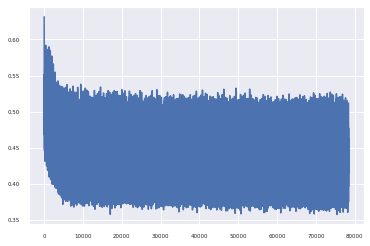

In [10]:
e_losses = []
num_epochs = 200
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)
plt.plot(e_losses)

# Results, Outputs & Data Eval

## k_ml distribution

In [17]:
net.eval()
with torch.no_grad():
    result = net(X_torch[0:1000000,0:11])
    #result = torch.round(result)
print(result.shape)
print(torch.max(result))
print(torch.min(result))
#df_result = df_orig.copy()
df_result = pd.DataFrame(data=result.numpy())
#result_df = pd.concat([df, df_F], axis=1)
df_result.columns = ["k_ml"]
df_result = pd.concat([df_result, df_orig], axis=1)
fig = px.histogram(df_result,x="k_ml",nbins=100,log_y=True,color="glabel")
fig.update_xaxes(range=[0.0,1.0])
fig.show()

torch.Size([195899, 1])
tensor(0.9508)
tensor(0.0345)


## Gamma-Rays(k_ml)

In [23]:
fig = px.histogram(df_result[(df_result['k_ml'] > 0.5)],
                   x="ge",nbins=1000,color="glabel")
fig.show()
